In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image
from collections import Counter
from IPython.display import clear_output

In [2]:
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/AI_Cons/hw3_data

Mounted at /content/drive
/content/drive/MyDrive/AI_Cons/hw3_data


In [3]:
'''
Part 1:  Write a function that takes just one argument — the name of the CSV file – and generates a
split of the images into train (70%), validation (15%) and test sets (15%). Each split should
have approximately the same proportion of giraffe images and zebra images (and images
containing both), but the images should be randomly assigned to the splits otherwise. Create
output that shows the split.
'''

df = pd.read_csv('metadata.csv')

conditions = [
    (df['giraffe'] == 0) & (df['zebra'] == 0),
    (df['giraffe'] == 1) & (df['zebra'] == 0),
    (df['giraffe'] == 0) & (df['zebra'] == 1),
    (df['giraffe'] == 1) & (df['zebra'] == 1)
    ]

values = [0, 1, 2, 3]
df['flag'] = np.select(conditions, values)

train = df.groupby('flag').sample(frac = 0.7)
print("Train Statistics")
print("None:", len(train[(train['giraffe'] == 0) & (train['zebra'] == 0)]))
print("Giraffe:", len(train[(train['giraffe'] == 1) & (train['zebra'] == 0)]))
print("Zebra:", len(train[(train['giraffe'] == 0) & (train['zebra'] == 1)]))
print("Both:", len(train[(train['giraffe'] == 1) & (train['zebra'] == 1)]))

valid = df.groupby('flag').sample(frac = 0.15)
print("\nValid Statistics")
print("None:", len(valid[(valid['giraffe'] == 0) & (valid['zebra'] == 0)]))
print("Giraffe:", len(valid[(valid['giraffe'] == 1) & (valid['zebra'] == 0)]))
print("Zebra:", len(valid[(valid['giraffe'] == 0) & (valid['zebra'] == 1)]))
print("Both:", len(valid[(valid['giraffe'] == 1) & (valid['zebra'] == 1)]))

test = df.groupby('flag').sample(frac = 0.15)
print("\nTest Statistics")
print("None:", len(test[(test['giraffe'] == 0) & (test['zebra'] == 0)]))
print("Giraffe:", len(test[(test['giraffe'] == 1) & (test['zebra'] == 0)]))
print("Zebra:", len(test[(test['giraffe'] == 0) & (test['zebra'] == 1)]))
print("Both:", len(test[(test['giraffe'] == 1) & (test['zebra'] == 1)]))
test = test['filename']


Train Statistics
None: 0
Giraffe: 380
Zebra: 3079
Both: 5

Valid Statistics
None: 0
Giraffe: 81
Zebra: 660
Both: 1

Test Statistics
None: 0
Giraffe: 81
Zebra: 660
Both: 1


In [4]:
'''
Part 2: Write a subclass of the PyTorch Dataset class that implements the functionality to creates
datasets for your train, validation and test splits. The class should include transformations
to map your image into the appropriate format and to resize to the correct input size for your network.
'''

class MyDataset(Dataset):
    def __init__(self,
                 csv_file,      # images could be provided with in a series of directories
                 root_dir,     # images could be provided as a list as well
                 transform = transforms.ToTensor()):  # provide transformation to apply to each image
      """
      Organize the images and the associated labels into two lists.  Potentially create additional
      lists if more complicated information is need.  Important note: images are NOT
      read and stored in this initializer.  They are read in __getitem__ as needed.
      """
      self.csv_file = csv_file
      self.root_dir = root_dir
      %cd $self.root_dir
      self.images = pd.read_csv(self.csv_file)
      # Record the transform that may need to be applied.
      self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        '''
        Return a tuple with the data, ground truth label, and any other data
        associated with a single image.
        '''
        img_name = self.images.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, img_name)
        im = Image.open(img_name)

        if self.transform is not None:
            im = self.transform(im)

        isGiraffe = self.images.iloc[idx, 1]
        isZebra = self.images.iloc[idx, 2]
        if isGiraffe and isZebra:
          label = 'Both'
        elif isGiraffe:
          label = 'Giraffe'
        elif isZebra:
          label = 'Zebra'
        else:
          label = 'None'

        return im, label


In [5]:
# B/W & convert image to pytorch tensors
image_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1), \
                                       transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = MyDataset(csv_file='/content/drive/MyDrive/AI_Cons/hw3_data/metadata.csv',
                    root_dir='/content/drive/MyDrive/AI_Cons/hw3_data/images/',
                    transform=image_transforms
                   )

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15], generator=torch.Generator())


/content/drive/MyDrive/AI_Cons/hw3_data/images


In [6]:
'''
Part 3: Write code that tests your Dataset class by iterating through the three instances you created
to show they are disjoint and include all images from the provided directory.
'''
train_set = set(train_dataset)
val_set = set(val_dataset)
test_set = set(test_dataset)
isDisjoint1 = train_set.intersection(val_set)
isDisjoint2 = test_set.intersection(val_set)
isDisjoint3 = train_set.intersection(test_set)

if (len(isDisjoint1)+len(isDisjoint2)+len(isDisjoint3)) == 0:
    print('The Datasets are Disjoint')
else:
    print('The Datasets are NOT Disjoint. Please check for errors.')

if (len(val_dataset)+len(train_dataset)+len(test_dataset)) == len(df):
    print("The Datasets contain all the images from the provided directory.")
else:
    print("The Datasets DO NOT contain all all images from the provided directory. Please check for errors.")

The Datasets are Disjoint
The Datasets contain all the images from the provided directory.


In [7]:
'''
Part 4: Write code to explore your three datasets, displaying statistics on the number of images of
each species in the split and displaying 10 randomly selected images. This type of data
exploration should be standard practice in your work.
'''
train_classes = [train_dataset[i][1] for i in range(len(train_dataset))]
val_classes = [val_dataset[i][1] for i in range(len(val_dataset))]
test_classes = [test_dataset[i][1] for i in range(len(test_dataset))]

train_counter = Counter(train_classes)
print("Train Statistics:")
print("Giraffe:", train_counter['Giraffe'])
print("Zebra:", train_counter['Zebra'])
print("Both:", train_counter['Both'])

val_counter = Counter(val_classes)
print("\nVal Statistics:")
print("Giraffe:", val_counter['Giraffe'])
print("Zebra:", val_counter['Zebra'])
print("Both:", val_counter['Both'])

test_counter = Counter(test_classes)
print("\nTest Statistics:")
print("Giraffe:", test_counter['Giraffe'])
print("Zebra:", test_counter['Zebra'])
print("Both:", test_counter['Both'])

Train Statistics:
Giraffe: 389
Zebra: 3070
Both: 5

Val Statistics:
Giraffe: 74
Zebra: 666
Both: 2

Test Statistics:
Giraffe: 80
Zebra: 662
Both: 0


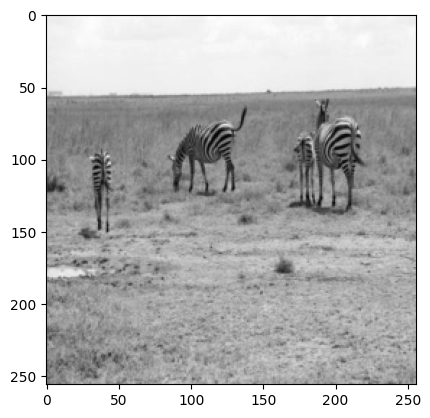

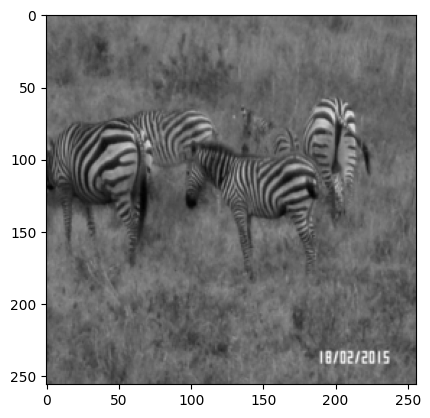

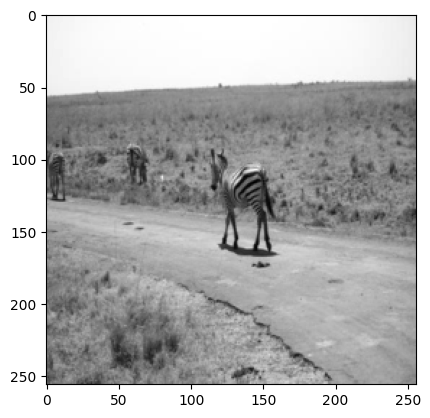

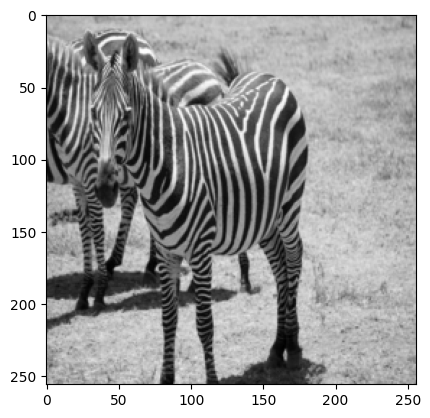

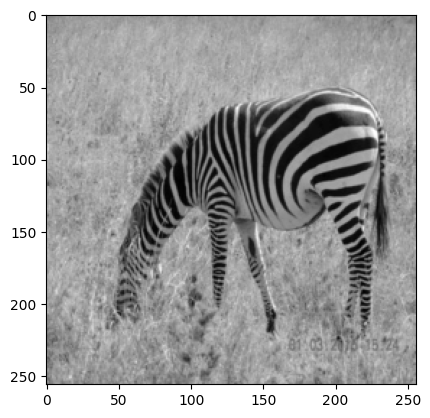

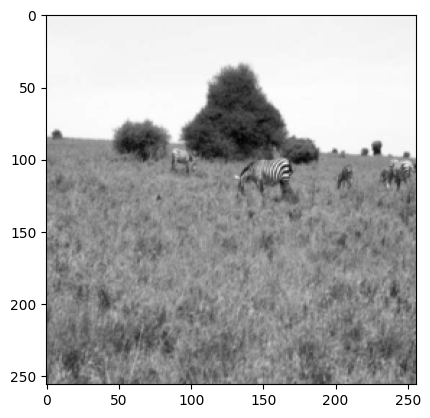

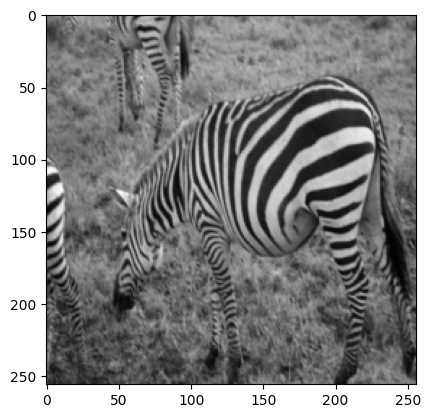

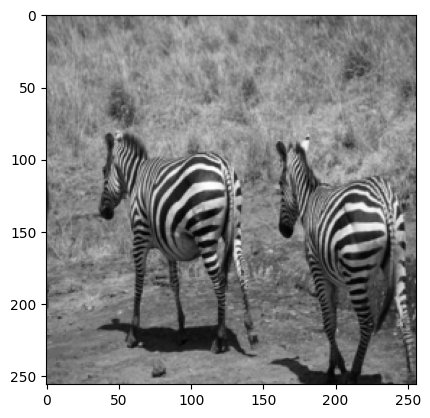

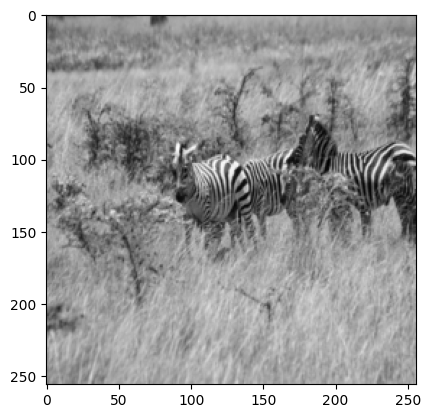

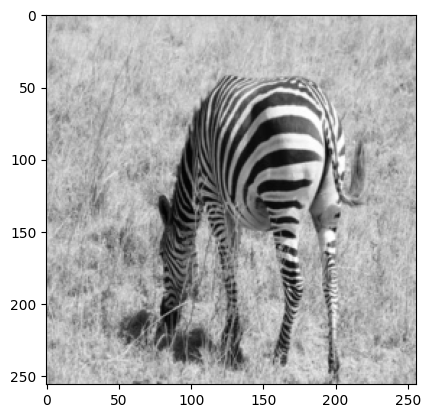

In [8]:
for i in range(10):
    idx = np.random.randint(0, len(dataset))
    im = dataset[idx][0]
    implot = plt.imshow(im.permute(1, 2, 0), cmap='gray') # found .permute() trick online to display tensor images
    plt.show()